In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_full = pd.read_csv('/clwork/kexin/tsar_st/a_misc./agg_results/simplifications_with_scores_20250820_135600.csv')

In [34]:
import pandas as pd

orig = pd.read_json("/clwork/kexin/tsar_st/data/source_with_difficulty.jsonl", 
                    lines=True, dtype={"text_id": str})[["text_id", "original", "difficulty_vector"]]
ref = pd.read_json("/clwork/kexin/tsar_st/data/references/human_simplifications.jsonl", 
                    lines=True, dtype={"text_id": str})[["text_id", "reference"]]

orig = orig.drop_duplicates(subset="text_id", keep="first")
df_full = df_full.merge(orig, on="text_id", how="left")

ref = ref.drop_duplicates(subset="text_id", keep="first")
df_full = df_full.merge(ref, on="text_id", how="left")

In [35]:
df_full['meaning_preservation'] = (df_full['meaningbert_orig'] + df_full['bertscore_f1_orig']) / 2
df_full['reference_similarity'] = (df_full['meaningbert_ref'] + df_full['bertscore_f1_ref']) / 2
df_full['cefr_accuracy'] = (df_full['target_cefr'] == df_full['predicted_cefr']).astype(int)

conditions = [
    df_full['cefr_accuracy'] == 1,       # exact match
    df_full['cefr_adj_accuracy'] == 1    # adjacent match
]
choices = [2, 1] # 2 for Exact, 1 for Adjacent
df_full['accuracy_category'] = np.select(conditions, choices, default=0) # 0 for Not Adjacent

In [36]:
# average probability for the target CEFR level for a simplification
def get_avg_target_prob(row):
    target_level = row['target_cefr']

    prob_col_1 = f"cefr_probas_ModernBERT-base-doc_en-Cefr_{target_level}"
    prob_col_2 = f"cefr_probas_ModernBERT-base-doc_sent_en-Cefr_{target_level}"
    prob_col_3 = f"cefr_probas_ModernBERT-base-reference_AllLang-Cefr_{target_level}"

    prob1 = row[prob_col_1]
    prob2 = row[prob_col_2]
    prob3 = row[prob_col_3]
    return (prob1 + prob2 + prob3) / 3

df_full['avg_target_cefr_prob'] = df_full.apply(get_avg_target_prob, axis=1)

print(df_full[['target_cefr', 'avg_target_cefr_prob']].head())

  target_cefr  avg_target_cefr_prob
0          A2              0.913810
1          B1              0.045045
2          A2              0.717406
3          B1              0.483983
4          A2              0.990061


In [ ]:
# import math
# import pandas as pd
# import spacy
# from rapidfuzz.distance import Levenshtein
# import sacrebleu

# # spaCy setup
# nlp = spacy.load("en_core_web_sm")

# def spacy_tokens(text):
#     if text is None or (isinstance(text, float) and math.isnan(text)):
#         return []
#     return [t.text for t in nlp(str(text))]

# PAIRS = [
#     ("original", "simplified"),
#     ("reference", "simplified"),
#     ("original", "reference"),
# ]

# def wer_from_lev(ref_toks, hyp_toks):
#     N = len(ref_toks)
#     if N == 0:
#         return 0.0 if len(hyp_toks) == 0 else 1.0
#     # Token-level Levenshtein distance == S+D+I
#     return Levenshtein.distance(ref_toks, hyp_toks) / N

# def compute_all_metrics(df: pd.DataFrame, pairs=PAIRS) -> pd.DataFrame:
#     rows = []
#     for idx, row in df.iterrows():
#         out = {"_row": idx}
#         cache = {}
#         for col in {"original", "reference", "simplified"} & set(df.columns):
#             cache[col] = spacy_tokens(row.get(col, ""))

#         for ref_col, hyp_col in pairs:
#             if ref_col not in cache or hyp_col not in cache:
#                 continue
#             ref_t, hyp_t = cache[ref_col], cache[hyp_col]
#             key = f"{hyp_col}_vs_{ref_col}"

#             # Levenshtein normalized distance (0..1), token-level
#             out[f"lev_{key}"] = Levenshtein.normalized_distance(ref_t, hyp_t)

#             # WER from Levenshtein distance (token-level)
#             out[f"wer_{key}"] = wer_from_lev(ref_t, hyp_t)

#             # TER (true TER with block shifts)
#             ref_str, hyp_str = " ".join(ref_t), " ".join(hyp_t)
#             out[f"ter_{key}"] = sacrebleu.corpus_ter([hyp_str], [[ref_str]]).score / 100.0

#         rows.append(out)

#     metrics = pd.DataFrame(rows).set_index("_row")
#     return df.join(metrics, how="left")

In [ ]:
import math
import pandas as pd
import spacy
from rapidfuzz.distance import Levenshtein
import sacrebleu

# spaCy setup
nlp = spacy.load("en_core_web_sm")

def spacy_tokens(text):
    if text is None or (isinstance(text, float) and math.isnan(text)):
        return []
    return [t.text for t in nlp(str(text))]

PAIRS = [("original", "simplified")]

def compute_all_metrics(
    df: pd.DataFrame,
    pairs=PAIRS,
    norm_by: str = "original",  # <<--- fixed field to normalize by
) -> pd.DataFrame:
    """
    norm_by: one of {"original", "reference", "simplified"}.
             Each row's normalization denominator = token count of this column.
             Useful to compare across instances with a consistent yardstick.
    """
    rows = []
    for idx, row in df.iterrows():
        out = {"_row": idx}
        cache = {}
        available_cols = {"original", "reference", "simplified"} & set(df.columns)

        # Tokenize once per row
        for col in available_cols:
            cache[col] = spacy_tokens(row.get(col, ""))

        # Denominator for fixed-field normalization (per row, same for all pairs)
        denom = len(cache.get(norm_by, []))
        denom = denom if denom > 0 else None  # avoid divide-by-zero

        for ref_col, hyp_col in pairs:
            if ref_col not in cache or hyp_col not in cache:
                continue
            ref_t, hyp_t = cache[ref_col], cache[hyp_col]
            key = f"{hyp_col}_vs_{ref_col}"

            # --- RAW Levenshtein edits (token-level) ---
            dist = Levenshtein.distance(ref_t, hyp_t)
            out[f"lev_raw_{key}"] = float(dist)

            # --- Fixed-field normalized Levenshtein ---
            # (same denominator across all pairs in this row)
            out[f"lev_norm_{norm_by}_{key}"] = (dist / denom) if denom else None

        rows.append(out)

    metrics = pd.DataFrame(rows).set_index("_row")
    return df.join(metrics, how="left")

In [50]:
orig_ref = orig.merge(ref, on="text_id", how="left")
df_human = compute_all_metrics(df=orig_ref, pairs=[("original", "reference")],)

In [51]:
df_human.head()

,text_id,original,difficulty_vector,reference,lev_raw_reference_vs_original,lev_norm_original_reference_vs_original
0,01-a2,Now NASA is working towards logging some of th...,"[1.8e-05, 0.062335999999999996, 0.588542999999...",Asteroids are small rocks in space. NASA is co...,72.0,0.888889
1,01-b1,Now NASA is working towards logging some of th...,"[1.8e-05, 0.062335999999999996, 0.588542999999...",Asteroids are rocks that fly through space. NA...,81.0,1.000000
2,02-a2,"Earthquakes damage all structures, including b...","[0.000297, 0.28598599999999996, 0.350603, 0.33...",An earthquake means when the ground shakes a l...,42.0,1.000000
3,02-b1,"Earthquakes damage all structures, including b...","[0.000297, 0.28598599999999996, 0.350603, 0.33...","Earthquakes damage all kinds of buildings, inc...",22.0,0.523810
4,03-a2,"The Hunger Games are an annual event, which th...","[0.000126, 0.610339, 0.327943, 0.061591, 0.0, ...",The 'Hunger Games' happen every year. Why? To ...,62.0,0.815789


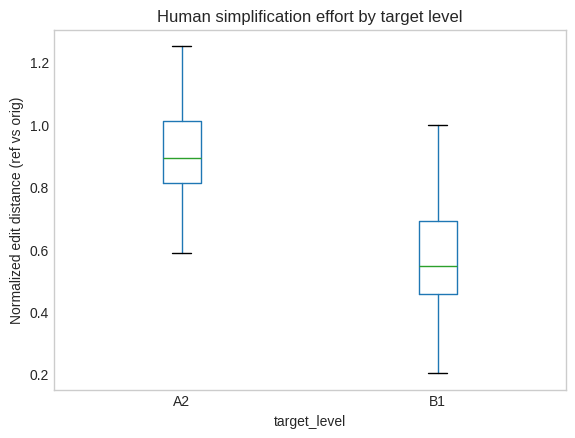

In [55]:
import matplotlib.pyplot as plt

# Boxplot of normalized edit distance (reference vs original) per target level
df_human.boxplot(column="lev_norm_original_reference_vs_original", by="target_level", grid=False)
plt.ylabel("Normalized edit distance (ref vs orig)")
plt.title("Human simplification effort by target level")
plt.suptitle("")  # remove automatic suptitle
plt.show()


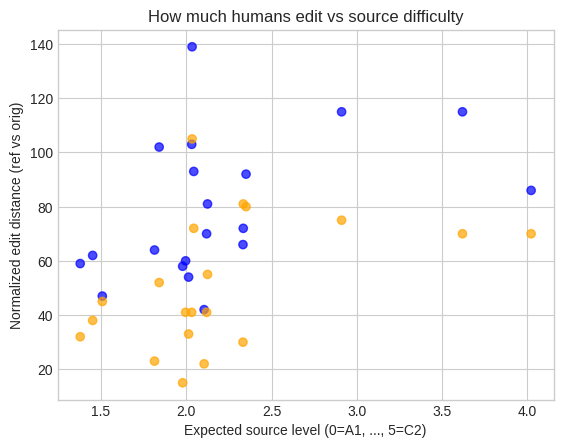

In [57]:
import numpy as np

LEVELS = ["A1","A2","B1","B2","C1","C2"]

def expected_level(probs):
    arr = np.array(probs)
    arr = arr / arr.sum()
    return (arr * np.arange(len(arr))).sum()

df_human["src_expect"] = df_human["difficulty_vector"].apply(expected_level)

plt.scatter(df_human["src_expect"], df_human["lev_raw_reference_vs_original"], 
            c=df_human["target_level"].map({"A2":"blue","B1":"orange"}), alpha=0.7)

plt.xlabel("Expected source level (0=A1, ..., 5=C2)")
plt.ylabel("Normalized edit distance (ref vs orig)")
plt.title("How much humans edit vs source difficulty")
plt.show()


In [38]:
df_metrics = compute_all_metrics(df_full)
# print(df_metrics.head())
# df_metrics.to_csv("all_simplifications_enriched.csv", index=False)

In [71]:
df_metrics["src_expect"] = df_metrics["difficulty_vector"].apply(expected_level)

LEVELS = ["A1","A2","B1","B2","C1","C2"]
idx = {lvl:i for i,lvl in enumerate(LEVELS)}
def diffvec_features(vec, target):
    p = vec / vec.sum()
    t = idx[target]
    E = (p * np.arange(len(p))).sum()
    gap = E - t
    return pd.Series({"gap":gap, "src_entropy": -np.sum(p*np.log(p+1e-9))})

df_metrics = df_metrics.join(df_metrics.apply(lambda r: diffvec_features(r["difficulty_vector"], r["target_cefr"]), axis=1))


AttributeError: 'list' object has no attribute 'sum'

In [65]:
front_cols = [
    "text_id",
    "experiment_run",
    "original",
    "src_expect",
    "reference",
    "simplified",
    "target_cefr",
    "predicted_cefr",
    "predicted_cefr_confidence",
    'cefr_accuracy',
    'cefr_adj_accuracy', 
    "lev_raw_simplified_vs_original", "lev_norm_original_simplified_vs_original",
    'meaningbert_orig', 'bertscore_f1_orig', 'meaning_preservation',
    'meaningbert_ref', 'bertscore_f1_ref','reference_similarity'
]

# build full column order: selected ones first, then all remaining (in original order)
new_order = front_cols + [col for col in df_metrics.columns if col not in front_cols]

# reorder
df_full = df_metrics[new_order]

# check
print(df_full.columns)

Index(['text_id', 'experiment_run', 'original', 'src_expect', 'reference',
       'simplified', 'target_cefr', 'predicted_cefr',
       'predicted_cefr_confidence', 'cefr_accuracy', 'cefr_adj_accuracy',
       'lev_raw_simplified_vs_original',
       'lev_norm_original_simplified_vs_original', 'meaningbert_orig',
       'bertscore_f1_orig', 'meaning_preservation', 'meaningbert_ref',
       'bertscore_f1_ref', 'reference_similarity', 'raw_model_output',
       'cefr_probas_ModernBERT-base-doc_en-Cefr_A1',
       'cefr_probas_ModernBERT-base-doc_en-Cefr_A2',
       'cefr_probas_ModernBERT-base-doc_en-Cefr_B1',
       'cefr_probas_ModernBERT-base-doc_en-Cefr_B2',
       'cefr_probas_ModernBERT-base-doc_en-Cefr_C1',
       'cefr_probas_ModernBERT-base-doc_en-Cefr_C2',
       'cefr_probas_ModernBERT-base-doc_sent_en-Cefr_A1',
       'cefr_probas_ModernBERT-base-doc_sent_en-Cefr_A2',
       'cefr_probas_ModernBERT-base-doc_sent_en-Cefr_B1',
       'cefr_probas_ModernBERT-base-doc_sent_en-Cef

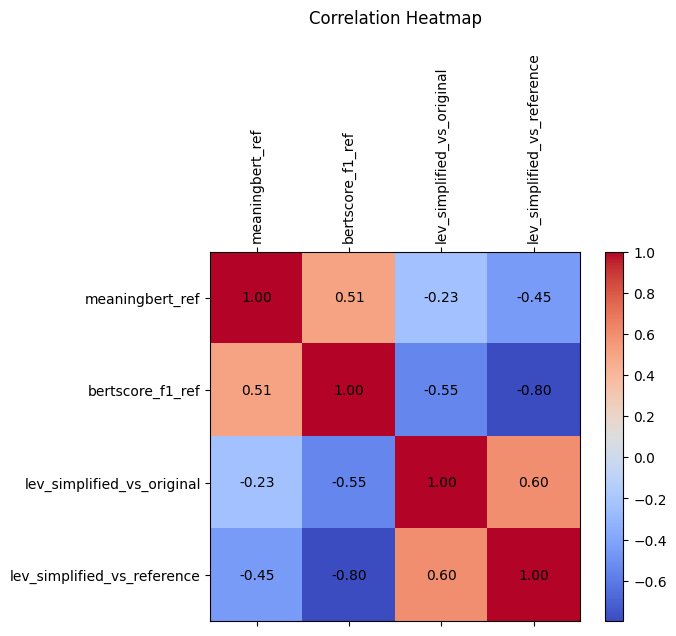

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

cols = ['meaningbert_ref', 'bertscore_f1_ref', 
        'lev_simplified_vs_original', 'lev_simplified_vs_reference']
df_subset = df_full[cols]

# Compute correlation matrix
corr = df_subset.corr(method="spearman")

# Plot heatmap
fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap="coolwarm")
plt.colorbar(cax)

# Set axis ticks
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Annotate each cell with correlation value
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", 
                ha="center", va="center", color="black")

plt.title("Correlation Heatmap", pad=20)
plt.show()


Boundary for high-quality items drawn at:
  - Min Meaning Preservation: 0.931
  - Min Reference Similarity: 0.891

Number of high-quality items considered non-adjacent: 0
Number of high-quality items that were adjacent but not exact: 5
Number of high-quality items that were an exact match: 0


/tmp/ipykernel_3825612/2757459120.py:31: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  ax.legend(handles=handles, labels=['Not Adjacent', 'Adjacent Only', 'Exact Match'], title='Accuracy Category')


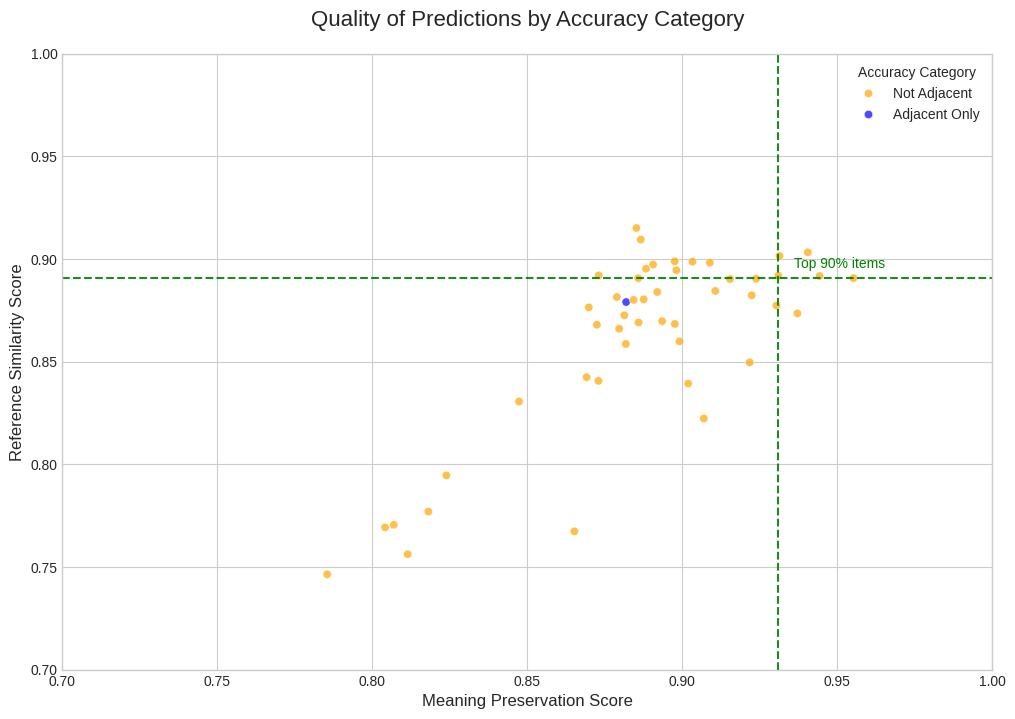

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Isolate one text_id for visualization
text_id_to_analyze = '05-b1'
df = df_full[df_full['text_id'] == text_id_to_analyze].copy()

# 3. Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

scatter = sns.scatterplot(
    data=df,
    x='meaning_preservation',
    y='reference_similarity',
    hue='accuracy_category',
    palette={0: 'red', 1: 'orange', 2: 'blue'},
    alpha=0.7,
    ax=ax
)

ax.set_title('Quality of Predictions by Accuracy Category', fontsize=16, pad=20)
ax.set_xlabel('Meaning Preservation Score', fontsize=12)
ax.set_ylabel('Reference Similarity Score', fontsize=12)
ax.set_xlim([0.7, 1.0])
ax.set_ylim([0.7, 1.0])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Not Adjacent', 'Adjacent Only', 'Exact Match'], title='Accuracy Category')

# 4. Visualization of adaptive threshold using combined score (2d quadrant)

df['combined_quality'] = (df['meaning_preservation'] + df['reference_similarity']) / 2

quantile_threshold = 0.9
combined_threshold = df['combined_quality'].quantile(quantile_threshold)
high_quality_items = df[df['combined_quality'] > combined_threshold]

if not high_quality_items.empty:
    min_meaning_for_high_quality = high_quality_items['meaning_preservation'].min()
    min_similarity_for_high_quality = high_quality_items['reference_similarity'].min()

    ax.axvline(min_meaning_for_high_quality, ls='--', color='green', alpha=0.9)
    ax.axhline(min_similarity_for_high_quality, ls='--', color='green', alpha=0.9)
    ax.text(min_meaning_for_high_quality + 0.005,
            min_similarity_for_high_quality + 0.005,
            f'Top {int(quantile_threshold*100)}% items',
            color='green',
            fontsize=10)
    print(f"\nBoundary for high-quality items drawn at:")
    print(f"  - Min Meaning Preservation: {min_meaning_for_high_quality:.3f}")
    print(f"  - Min Reference Similarity: {min_similarity_for_high_quality:.3f}")
else:
    print("\nNo items found above the combined quality threshold. Lines not drawn.")


# 6. Analysis
high_quality_thrown_away = df[
    (df['accuracy_category'] == 0) &
    (df['combined_quality'] > combined_threshold)
]
print(f"\nNumber of high-quality items considered non-adjacent: {len(high_quality_thrown_away)}")

high_quality_adjacent_only = df[
    (df['accuracy_category'] == 1) &
    (df['combined_quality'] > combined_threshold)
]
print(f"Number of high-quality items that were adjacent but not exact: {len(high_quality_adjacent_only)}")

high_quality_exact = df[
    (df['accuracy_category'] == 2) &
    (df['combined_quality'] > combined_threshold)
]
print(f"Number of high-quality items that were an exact match: {len(high_quality_exact)}")


Boundary for high-quality items drawn at:
  - Min Meaning Preservation: 0.891
  - Min Reference Similarity: 0.879


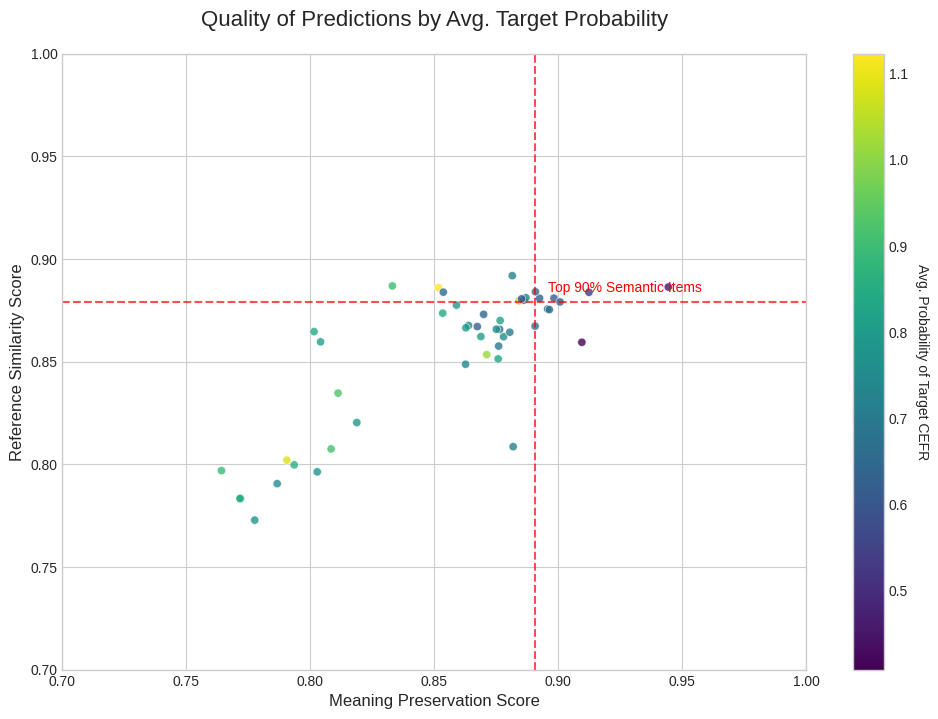

In [69]:
# 1. Isolate one text_id for visualization
text_id_to_analyze = '01-a2'
df = df_full[df_full['text_id'] == text_id_to_analyze].copy()

# 2. Calculate the new probability column
df['avg_target_cefr_prob'] = df.apply(get_avg_target_prob, axis=1)

# 3. Visualization using the new probability score
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Use 'avg_target_cefr_prob' for the hue to create a color gradient.
scatter = sns.scatterplot(
    data=df,
    x='meaning_preservation',
    y='reference_similarity',
    hue='lev_norm_original_simplified_vs_original', # Changed from 'accuracy_category'
    palette='viridis',          # Using a continuous color palette
    alpha=0.8,
    ax=ax
)

ax.set_title('Quality of Predictions by Avg. Target Probability', fontsize=16, pad=20)
ax.set_xlabel('Meaning Preservation Score', fontsize=12)
ax.set_ylabel('Reference Similarity Score', fontsize=12)
ax.set_xlim([0.7, 1.0])
ax.set_ylim([0.7, 1.0])

# The legend is now a color bar, handled automatically by seaborn.
norm = plt.Normalize(df['lev_norm_original_simplified_vs_original'].min(), df['lev_norm_original_simplified_vs_original'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.get_legend().remove()
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Avg. Probability of Target CEFR', rotation=270, labelpad=15)


# 4. Visualization of adaptive threshold using combined score (2d quadrant)
# This part remains the same, showing the top semantic quality region.
df['combined_quality'] = (df['meaning_preservation'] + df['reference_similarity']) / 2

quantile_threshold = 0.9
combined_threshold = df['combined_quality'].quantile(quantile_threshold)
high_quality_items = df[df['combined_quality'] > combined_threshold]

if not high_quality_items.empty:
    min_meaning_for_high_quality = high_quality_items['meaning_preservation'].min()
    min_similarity_for_high_quality = high_quality_items['reference_similarity'].min()

    ax.axvline(min_meaning_for_high_quality, ls='--', color='red', alpha=0.7)
    ax.axhline(min_similarity_for_high_quality, ls='--', color='red', alpha=0.7)
    ax.text(min_meaning_for_high_quality + 0.005,
            min_similarity_for_high_quality + 0.005,
            f'Top {int(quantile_threshold*100)}% Semantic Items',
            color='red',
            fontsize=10)
    print(f"\nBoundary for high-quality items drawn at:")
    print(f"  - Min Meaning Preservation: {min_meaning_for_high_quality:.3f}")
    print(f"  - Min Reference Similarity: {min_similarity_for_high_quality:.3f}")
else:
    print("\nNo items found above the combined quality threshold. Lines not drawn.")

In [84]:
def identify_pareto(df, score1_col, score2_col):
    """
    Identifies the Pareto front from a DataFrame based on two scores to be maximized.
    Returns a boolean Series indicating if a row is on the Pareto front.
    """
    # Create a copy of the DataFrame with a fresh, sequential index to avoid errors.
    df_copy = df[[score1_col, score2_col]].copy().reset_index(drop=True)
    is_pareto = np.ones(df_copy.shape[0], dtype=bool)

    # Iterate using the new sequential index from the copied DataFrame.
    for i, row in df_copy.iterrows():
        score1 = row[score1_col]
        score2 = row[score2_col]
        
        # Check if any other point dominates the current point.
        # A point is dominated if another point is better or equal on all scores,
        # and strictly better on at least one score.
        if ((df_copy[score1_col] >= score1) & (df_copy[score2_col] >= score2) & 
            ((df_copy[score1_col] > score1) | (df_copy[score2_col] > score2))).any():
            is_pareto[i] = False
            
    return is_pareto


Found 5 candidates on the Pareto front.


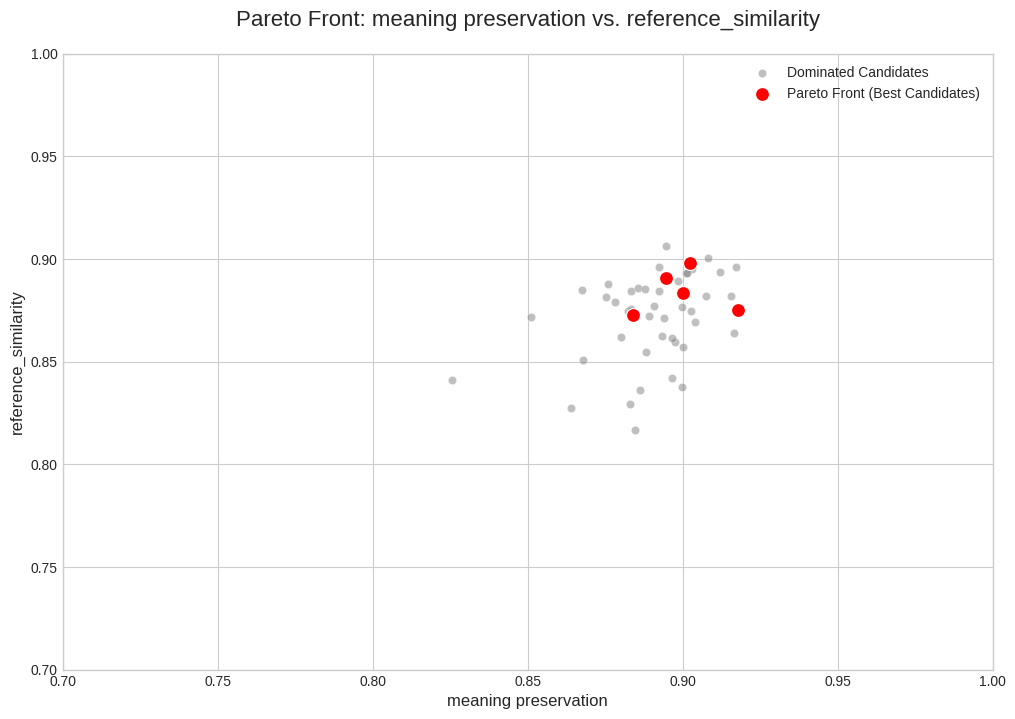

In [99]:
text_id_to_analyze = '06-a2'
df = df_full[df_full['text_id'] == text_id_to_analyze].copy()
df.dropna(subset=['meaning_preservation', 'avg_target_cefr_prob'], inplace=True)

# --- Section 3: Pareto Front Calculation & Visualization ---

# Identify the Pareto front points
df['is_pareto'] = identify_pareto(df, 'meaning_preservation', 'avg_target_cefr_prob')

print(f"Found {df['is_pareto'].sum()} candidates on the Pareto front.")

# Create the visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all the points
sns.scatterplot(
    data=df,
    x='meaning_preservation',
    y='reference_similarity',
    color='gray',
    alpha=0.5,
    ax=ax,
    label='Dominated Candidates'
)

# Highlight the Pareto front points
sns.scatterplot(
    data=df[df['is_pareto']],
    x='meaning_preservation',
    y='reference_similarity',
    color='red',
    s=100, # Make them larger
    ax=ax,
    label='Pareto Front (Best Candidates)'
)

# Improve the plot's readability
ax.set_title('Pareto Front: meaning preservation vs. reference_similarity', fontsize=16, pad=20)
ax.set_xlabel('meaning preservation', fontsize=12)
ax.set_ylabel('reference_similarity', fontsize=12)
ax.legend()
ax.set_xlim([0.7, 1.0])
ax.set_ylim([0.7, 1.0])
plt.show()

In [104]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist
import warnings

# Suppress pandas warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

print("✅ Libraries imported.")

# --- 1. Load a Powerful Embedding Model ---
# We'll use a strong, all-around model from the sentence-transformers library.
# This model is excellent at capturing nuanced semantic meaning.
try:
    print("Loading embedding model 'all-mpnet-base-v2'... (This may take a moment on first run)")
    model = SentenceTransformer('all-mpnet-base-v2')
    print("✅ Embedding model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model. Please ensure you have an internet connection and 'sentence-transformers' installed (`pip install sentence-transformers`). Error: {e}")
    # Exit if model fails to load
    exit()

✅ Libraries imported.
Loading embedding model 'all-mpnet-base-v2'... (This may take a moment on first run)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Embedding model loaded successfully.


In [105]:
# --- 2. Define the Conformity Score Function ---
def calculate_conformity(group):
    """
    Calculates embeddings and conformity scores for a group of simplified texts.
    A candidate's conformity score is its average cosine similarity to its peers.
    """
    # Ensure there's more than one candidate to compare against
    if len(group) < 2:
        group['conformity_score'] = np.nan
        return group

    # Generate embeddings for all simplified texts in the group
    embeddings = model.encode(group['simplified'].tolist(), show_progress_bar=False)

    # Calculate the pairwise cosine distance matrix and convert it to a similarity matrix
    # cdist calculates distance (0=identical, 2=opposite), so we subtract from 1 for similarity
    similarity_matrix = 1 - cdist(embeddings, embeddings, 'cosine')

    # Calculate the average similarity for each candidate to its peers
    # We subtract 1 from the sum to exclude the self-similarity (which is always 1)
    # and divide by (n-1) peers.
    sum_of_similarities = similarity_matrix.sum(axis=1) - 1
    num_peers = len(group) - 1
    conformity_scores = sum_of_similarities / num_peers

    group['conformity_score'] = conformity_scores
    return group

In [106]:
# --- 3. Process the DataFrame ---

# Group by the original text and apply the function to calculate scores
# This ensures we only compare candidates generated from the same source.
df_full = df_full.groupby('text_id', group_keys=False).apply(calculate_conformity)

print("\n✅ Conformity Score calculated for all candidates.")
print("Here's a sample of the results:")
print(df_full[['text_id', 'simplified', 'conformity_score']].head())


✅ Conformity Score calculated for all candidates.
Here's a sample of the results:
  text_id                                         simplified  conformity_score
0   01-a2  NASA is trying to find and count smaller aster...          0.859481
1   01-b1  Now NASA is working to find and record some of...          0.945142
2   02-a2  Earthquakes can break buildings and bridges. B...          0.896570
3   02-b1  Earthquakes damage all buildings, including br...          0.955844
4   03-a2  The Hunger Games happen every year. The Capito...          0.945326


In [107]:
# --- 4. Analyze the Strength of the New Feature ---
# Now, let's see if the 'conformity_score' correlates with our other quality metrics.
# A strong positive correlation would suggest it's a good proxy for quality.

# Drop rows where conformity score couldn't be calculated (groups of 1)
analysis_df = df_full.dropna(subset=['conformity_score'])

if not analysis_df.empty:
    correlation_cefr = analysis_df['conformity_score'].corr(analysis_df['cefr_adj_accuracy'])
    correlation_meaning = analysis_df['conformity_score'].corr(analysis_df['meaning_preservation'])
    correlation_reference = analysis_df['conformity_score'].corr(analysis_df['reference_similarity'])

    print("\n--- Correlation Analysis ---")
    print(f"Correlation with CEFR Adj. Accuracy: {correlation_cefr:.3f}")
    print(f"Correlation with Meaning Preservation: {correlation_meaning:.3f}")
    print(f"Correlation with Reference Similarity: {correlation_reference:.3f}")
else:
    print("\n--- Correlation Analysis ---")
    print("Could not perform correlation analysis. The resulting DataFrame was empty.")


--- Correlation Analysis ---
Correlation with CEFR Adj. Accuracy: 0.124
Correlation with Meaning Preservation: 0.385
Correlation with Reference Similarity: 0.203


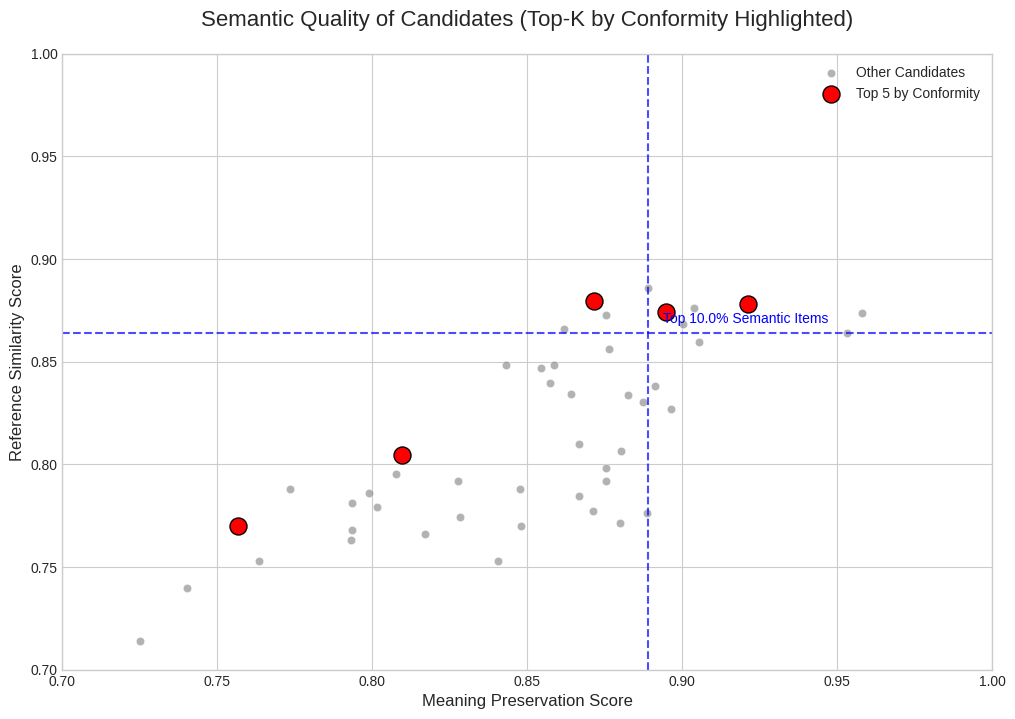

In [122]:
text_id_to_analyze = '05-a2'
df = df_full[df_full['text_id'] == text_id_to_analyze].copy()

# Identify the top-k candidates to highlight
k = 5
top_k_indices = df['conformity_score'].nlargest(k).index
df['is_top_k'] = False
df.loc[top_k_indices, 'is_top_k'] = True

# Create the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all the non-top-k points first in a muted color
sns.scatterplot(
    data=df[~df['is_top_k']],
    x='meaning_preservation',
    y='reference_similarity',
    color='gray',
    alpha=0.6,
    ax=ax,
    label='Other Candidates'
)

# Plot the top-k points on top with a distinct color and larger size
sns.scatterplot(
    data=df[df['is_top_k']],
    x='meaning_preservation',
    y='reference_similarity',
    color='red',
    s=150, # Make them larger
    edgecolor='black',
    ax=ax,
    label=f'Top {k} by Conformity'
)

# Set titles, labels, and limits
ax.set_title('Semantic Quality of Candidates (Top-K by Conformity Highlighted)', fontsize=16, pad=20)
ax.set_xlabel('Meaning Preservation Score', fontsize=12)
ax.set_ylabel('Reference Similarity Score', fontsize=12)
ax.set_xlim([0.7, 1.0])
ax.set_ylim([0.7, 1.0])
ax.legend()

# Optional: Add the semantic quality threshold lines for context
df['combined_quality'] = (df['meaning_preservation'] + df['reference_similarity']) / 2
quantile_threshold = 0.9
combined_threshold = df['combined_quality'].quantile(quantile_threshold)
high_quality_items = df[df['combined_quality'] > combined_threshold]

if not high_quality_items.empty:
    min_meaning_for_high_quality = high_quality_items['meaning_preservation'].min()
    min_similarity_for_high_quality = high_quality_items['reference_similarity'].min()

    ax.axvline(min_meaning_for_high_quality, ls='--', color='blue', alpha=0.7)
    ax.axhline(min_similarity_for_high_quality, ls='--', color='blue', alpha=0.7)
    ax.text(min_meaning_for_high_quality + 0.005,
            min_similarity_for_high_quality + 0.005,
            f'Top {100-(quantile_threshold*100)}% Semantic Items',
            color='blue',
            fontsize=10)

plt.show()